<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=138508635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
purchase_time = '15:45:00'
# In dollars
commission = 1.5



files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
    #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-29-23.db
Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db
Copying db file to output : optimal-short-straddle-study_2019-2022_1DTE_1.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-30-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-28-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-27-23.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-27-19.db


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
    for f in filenames:
        if 'spx' in f:
            df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df.rename(columns={'underlying':'price'},inplace=True)
            df.drop(columns=['Unnamed: 0'], inplace=True)
            df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
            df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
            df['delta'] = df['delta'].abs()
            initial_portfolio_value = df.loc[1,'price']*20
        elif 'irx' in f:
            df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
            df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
            df_irx['Adj Close']*= 100
            df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
            df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
            df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
            df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)



# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

#########
# Abstract Strategy & Abstract Policy
#########

class AbstractStrategy(ABC):
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        
        # If another method overrode df_trades, we will respect it.
        if hasattr(self, 'df_trades') == False:
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 'collected', 'lost_c', 'lost_p'])
       
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c'] + df_trades['lost_p']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True, errors='ignore')

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n{'Dampened Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/np.sqrt(std_trans_return),3):>10}",
                f"\n"
            )
            
        # The reason this number outputs like this, is because we were running a optimizer,
        # and we wanted a single "fitness" value that the optimizer could optimize
        # TODO : if Debug = True, output a dictionary with all of the values above
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        damp_risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/np.sqrt(std_trans_return),3)
        return damp_risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractPolicy(ABC):
    def getRoundedSlippedPrice(self,bid,ask, trans_type):
        mid = (bid + ask)/0.02
        if mid % 1 != 0.0:
            # We need to slip the bid/ask spread
            if trans_type == 'sell':
                ask -= 0.05
            elif trans_type=='buy':
                bid += 0.05

        mid = round((bid + ask)/0.02,1)
        return mid
    
    def len_check(self,df, opt_type, strike, contract_date, quote_time):
        if len(df)==0:
            raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            target_delta = 0 if target_delta is None else target_delta
            print(f"WARNING : get_contract_strike no records found: {trans_type} Delta:{target_delta:.3f} {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']

        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")

        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    

In [4]:
#########
# AbstractEntry, AbstractDynamicEntryPolicy
#########

class AbstractEntryPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission):
        super().__init__(commission)
        
    @abstractmethod
    def populateTrades(self, data):
        pass
        
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

class AbstractDynamicEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission):
        super().__init__(commission)
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    



In [5]:
class OptionSelectorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self,commission, dte, trade_time, option_selector):
        self.dte = dte
        self.trade_time = trade_time
        self.option_selector = option_selector
        super().__init__(commission)
    
    def populateTrades(self, data):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        df_data = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        
        return self.option_selector.populateTrades(df_data, df_trades, self.get_contract_strike)
    
    def __str__(self):
        return str(self.option_selector)

    def __repr__(self):
        return str(self.option_selector)

In [6]:
# AbstractOptionSelector, DeltaOptionSelector, YieldOptionSelector
class AbstractOptionSelector(ABC):
    @abstractmethod
    def populateTrades(self, df_data, df_trades):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class DeltaOptionSelector(AbstractOptionSelector):
    def __init__(self, short_puts=None, short_calls=None, long_puts=None, long_calls=None):
        """
        Initializes the Delta Option Selector class. All params are target deltas
        
        :param short_puts: A float or list of deltas to open positions with
        :param short_calls: None/float/list
        :param long_puts: None/float/list
        :param long_calls: None/float/list
        :return: n/a
        """
        # Any of the input variables can be None, float, or a list of floats
        # TODO : Add type checking for list
        self.summary = "Delta "
        
        if short_puts is not None:
            self.short_puts = [short_puts] if type(short_puts) is float else short_puts
            for sp in self.short_puts:
                self.summary += f"SP: {sp:.3f} "
        else:
            self.short_puts = []
            
        if short_calls is not None:
            self.short_calls = [short_calls] if type(short_calls) is float else short_calls
            for sc in self.short_calls:
                self.summary += f"SC: {sc:.3f} "
        else:
            self.short_calls = []
            
        if long_puts is not None:
            self.long_puts = [long_puts] if type(long_puts) is float else long_puts
            for lp in self.long_puts:
                self.summary += f"LP: {lp:.3f} "
        else:
            self.long_puts = []
            
        if long_calls is not None:
            self.long_calls = [long_calls] if type(long_calls) is float else long_calls
            for lc in self.long_calls:
                self.summary += f"LC: {lc:.3f} "
        else:
            self.long_calls = []
            
        

        
    def populateTrades(self, df_data, df_trades, get_contract_strike):
        """
        Populates trades for the classes deltas 0 to n trades per day
        
        :param df_data: must be filtered for the proper date and time of trade entry
        :param df_trades: must contain rows pertaining to the trade dates
        :param get_contract_strike: method for obtaining the strike, data
        :return: df_trades with added columns for 
        """
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No rows were configured in df_trades. No backtest can be generated.")
            
        df_c = df_data[(df_data['type']=="C")].copy()
        df_p = df_data[(df_data['type']=="P")].copy()
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No puts were found with static rules.")
        
            
        # Add all short puts to df_trades
        for i in range(len(self.short_puts)):
            df_trades[f'delta_sp_target_{i}'] = self.short_puts[i]
            df_sp = df_p[df_p['delta']<= self.short_puts[i]]
            df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
            df_trades[f'strike_sp_{i}'],df_trades[f'delta_sp_{i}'],df_trades[f'collected_sp_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],row[f'delta_sp_target_{i}'], df_sp,'sell'), axis = 1).T.values
        
        # Add all short calls to df_trades
        for i in range(len(self.short_calls)):
            df_trades[f'delta_sc_target_{i}'] = self.short_calls[i]
            df_sc = df_c[df_c['delta']<= self.short_calls[i]]
            df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
            df_trades[f'strike_sc_{i}'],df_trades[f'delta_sc_{i}'],df_trades[f'collected_sc_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],row[f'delta_sc_target_{i}'], df_sc,'sell'), axis = 1).T.values

        # Add all long calls to df_trades
        for i in range(len(self.long_calls)):
            df_trades[f'delta_lc_target_{i}'] = self.long_calls[i]
            df_lc = df_c[df_c['delta']>= self.long_calls[i]]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
            df_lc = df_lc.loc[df_lc.groupby(['quote_date'])['delta'].idxmin()]
            df_trades[f'strike_lc_{i}'],df_trades[f'delta_lc_{i}'],df_trades[f'collected_lc_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],row[f'delta_lc_target_{i}'], df_lc, 'buy'), axis = 1).T.values
            df_trades[f'collected_lc_{i}'] = df_trades[f'collected_lc_{i}']*-1

        # Add all long puts to df_trades
        for i in range(len(self.long_puts)):
            df_trades[f'delta_lp_target_{i}'] = self.long_puts[i]
            df_lp = df_p[df_p['delta']>= self.long_puts[i]]
            df_lp = df_lp.loc[df_lp.groupby(['quote_date'])['delta'].idxmin()]
            df_trades[f'strike_lp_{i}'],df_trades[f'delta_lp_{i}'],df_trades[f'collected_lp_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],row[f'delta_lp_target_{i}'], df_lp, 'buy'), axis = 1).T.values
            df_trades[f'collected_lp_{i}']=df_trades[f'collected_lp_{i}']*-1

        filt_cols = [col for col in df_trades.columns.to_list() if "strike_" in col]
        df_trades['trade_count'] = df_trades.loc[:,filt_cols].astype(bool).sum(axis=1)
        
        filt_cols = [col for col in df_trades.columns.to_list() if "collected_" in col]
        df_trades['collected'] = df_trades.loc[:,filt_cols].sum(axis=1)
            
        return df_trades
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class YieldOptionSelector(AbstractOptionSelector):
    def __init__(self, short_puts=None, short_calls=None, long_puts=None, long_calls=None, ipv=None):
        """
        Initializes the Delta Option Selector class. All params are target deltas
        
        :param short_puts: A float or list of deltas to open positions with
        :param short_calls: None/float/list
        :param long_puts: None/float/list
        :param long_calls: None/float/list
        :return: n/a
        """
        # Any of the input variables can be None, float, or a list of floats
        # TODO : Add type checking for list
        
        if ipv is None:
            raise TypeError("Argument ipv cannot be NoneType. A non-zero value must be specified.")
        self.ipv = ipv
        
        self.summary = "Yields "
        self.target_tol = 1.2
        
        if short_puts is not None:
            self.short_puts = [short_puts] if type(short_puts) is float else short_puts
            for sp in self.short_puts:
                self.summary += f"SP: {sp:.3%} "
        else:
            self.short_puts = []
            
        if short_calls is not None:
            self.short_calls = [short_calls] if type(short_calls) is float else short_calls
            for sc in self.short_calls:
                self.summary += f"SC: {sc:.3%} "
        else:
            self.short_calls = []
            
        if long_puts is not None:
            self.long_puts = [long_puts] if type(long_puts) is float else long_puts
            for lp in self.long_puts:
                self.summary += f"LP: {lp:.3%} "
        else:
            self.long_puts = []
            
        if long_calls is not None:
            self.long_calls = [long_calls] if type(long_calls) is float else long_calls
            for lc in self.long_calls:
                self.summary += f"LC: {lc:.3%} "
        else:
            self.long_calls = []

        
    def populateTrades(self, df_data, df_trades, get_contract_strike):
        """
        Populates trades for the classes deltas 0 to n trades per day
        
        :param df_data: must be filtered for the proper date and time of trade entry
        :param df_trades: must contain rows pertaining to the trade dates
        :param get_contract_strike: method for obtaining the strike, data
        :return: df_trades with added columns for 
        """
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No rows were configured in df_trades. No backtest can be generated.")
            
        df_c = df_data[(df_data['type']=="C")].copy()
        df_p = df_data[(df_data['type']=="P")].copy()
        
        if df_c.shape[0] == 0:
            print(f"***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print(f"***WARNING*** : No puts were found with static rules.")
        
            
        # Add all short puts to df_trades
        for i in range(len(self.short_puts)):
            target = self.ipv*self.short_puts[i] / 100
            df_trades[f'yield_sp_target_{i}'] = self.short_puts[i]
            df_sp = df_p[df_p['ask']+df_p['bid'] < target*2*self.target_tol]
            df_sp = df_sp.loc[df_sp.groupby(['quote_date'])['strike'].idxmax()]
            df_trades[f'strike_sp_{i}'],df_trades[f'delta_sp_{i}'],df_trades[f'collected_sp_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],None, df_sp,'sell'), axis = 1).T.values
        
        # Add all short calls to df_trades
        for i in range(len(self.short_calls)):
            target = self.ipv*self.short_calls[i] / 100
            df_trades[f'yield_sc_target_{i}'] = self.short_calls[i]
            df_sc = df_c[df_c['ask'] + df_c['bid']< target*2*self.target_tol]
            df_sc = df_sc.loc[df_sc.groupby(['quote_date'])['strike'].idxmin()]            
            df_trades[f'strike_sc_{i}'],df_trades[f'delta_sc_{i}'],df_trades[f'collected_sc_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],None, df_sc,'sell'), axis = 1).T.values

        # Add all long calls to df_trades
        for i in range(len(self.long_calls)):
            target = self.ipv*self.long_calls[i] / 100
            df_trades[f'yield_lc_target_{i}'] = self.long_calls[i]
            df_lc = df_c[df_c['ask'] + df_c['bid']< target*2*self.target_tol]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
            df_lc = df_lc.loc[df_lc.groupby(['quote_date'])['strike'].idxmin()]
            df_trades[f'strike_lc_{i}'],df_trades[f'delta_lc_{i}'],df_trades[f'collected_lc_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],None, df_lc, 'buy'), axis = 1).T.values
            df_trades[f'collected_lc_{i}'] = df_trades[f'collected_lc_{i}']*-1

        # Add all long puts to df_trades
        for i in range(len(self.long_puts)):
            df_trades[f'yield_lp_target_{i}'] = self.long_puts[i]
            df_lp = df_p[df_p['ask']+df_p['bid'] < target*2*self.target_tol]
            df_lp = df_lp.loc[df_lp.groupby(['quote_date'])['strike'].idxmax()]
            df_trades[f'strike_lp_{i}'],df_trades[f'delta_lp_{i}'],df_trades[f'collected_lp_{i}'] = df_trades.apply(
                lambda row : get_contract_strike(row['trade_date'], row['expiration'],None, df_lp, 'buy'), axis = 1).T.values
            df_trades[f'collected_lp_{i}']=df_trades[f'collected_lp_{i}']*-1

        filt_cols = [col for col in df_trades.columns.to_list() if "strike_" in col]
        df_trades['trade_count'] = df_trades.loc[:,filt_cols].astype(bool).sum(axis=1)
        
        filt_cols = [col for col in df_trades.columns.to_list() if "collected_" in col]
        df_trades['collected'] = df_trades.loc[:,filt_cols].sum(axis=1)
            
        return df_trades
    
    
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [7]:
#####
# Dynamic Entry Policies
#####


class OptionSelectorDynamicEntryPolicy(AbstractDynamicEntryPolicy):
    def __init__(self,commission, dte, option_selector, dteMatch = 'eq'):
        self.dte = dte
        self.option_selector = option_selector
        
        dteMatchValues = ['leq','eq','geq']
        if dteMatch not in dteMatchValues:
            raise ValueError(f"Invalid argument passed in for dteMatch : {dteMatch}. Value must be one of {dteMatchValues}")
            
        self.dteMatch = dteMatch
        super().__init__(commission)
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        df_trades = None
        if (df_trade_row is None or (df_trade_row['expiration'] == eval_date and eval_time=='16:00:00') or df_trade_row['expiration'] < eval_date or df_trade_row['lost_p']>0 or df_trade_row['lost_c']>0):
            #populate a new trade
            trade_count = 0
            expiration_p, expiration_c = None, None

            # create call/put dataframe slice if needed
            if self.dteMatch == 'geq':
                df_purchase_time = df_data[(df_data['dte']>=self.dte) & (df_data['quote_time'] == eval_time)]
            elif self.dteMatch == 'eq':
                df_purchase_time = df_data[(df_data['dte']==self.dte) & (df_data['quote_time'] == eval_time)]
            else: 
                # The last option is dteMatch =='leq', meaning we will allow trades that are 0 dte up to (and including) the target dte
                df_purchase_time = df_data[(df_data['dte']<=self.dte) & (df_data['quote_time'] == eval_time)]
                # If the evaluation time is in the last 15 minutes, we don't want 0-DTE
                if eval_time>='15:45:00':
                    df_purchase_time = df_purchase_time[df_purchase_time['dte']>0]
                
            exp = df_purchase_time['expiration'].min()
            df_purchase_time = df_purchase_time[df_purchase_time['expiration']==exp]
            
            if df_purchase_time.shape[0] == 0:
                return None
                    
            df_trades = pd.DataFrame([{'trade_date':eval_date, 'expiration':exp, 'trade_count':trade_count, 'lost_c':0.0, 'lost_p':0.0}])
        
            return self.option_selector.populateTrades(df_purchase_time, df_trades, self.get_contract_strike)
        
#         print(f"Pre-conditions not satisfied. Eval date {eval_date}. eval time : {eval_time}")
#         print(f"df trade row type : {type(df_trade_row)}")
#         print(f"df trade row : {df_trade_row}")
#         print(f"eval date {eval_date}")
#         print(f"eval time {eval_time}")
              
        return None
    
    def __str__(self):
        return f"{str(self.option_selector)} DTE: {self.dte} Match: {self.dteMatch}"

    def __repr__(self):
        return f"{str(self.option_selector)} DTE: {self.dte} Match: {self.dteMatch}"

In [8]:
#### Basic Strategy Types

class StaticEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, df_ty, ipv, entry_policy, exit_policy, debug = False):
        if not isinstance(entry_policy, AbstractStaticEntryPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractStaticEntryPolicy'.")
            
        if not isinstance(exit_policy, AbstractDynamicExitPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractDynamicExitPolicy'.")
            
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        
        
        self.df_trades['lost_c'] = 0.0
        self.df_trades['lost_p'] = 0.0
        
        df_times = pd.DataFrame(df['quote_time'].unique())
        df_times[0] = pd.to_datetime(df_times[0], format='%H:%M:%S').dt.time
        df_times.rename(columns={0: "quote_time"},inplace=True)
        df_times = df_times.sort_values(by='quote_time')
        
        start_time_timer = perf_counter()
        for index, trow in df_times.iterrows():           
            min_i = int(trow[0].strftime("%M"))
            curr_time = trow[0]
            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            if (end_time < curr_time or curr_time <= start_time):
                continue
            str_quote_time = trow[0].strftime("%H:%M:%S")
            df_qt = df[(df['quote_time']==str_quote_time)]

            # print(f"Num rows at {str_quote_time} : {df_qt.shape[0]}")

            self.df_trades['trade_count'],self.df_trades['lost_c'], self.df_trades['lost_p'] = self.df_trades.apply(
                lambda row : self.exit_policy.evaluateTradingCondition(None, str_quote_time, row, df_qt), axis=1).T.values
            stop_time_timer = perf_counter()
            # print(df_trades.head())

            if min_i % 30 == 0:
                print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class DynamicEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, df_ty, ipv, entry_policy, exit_policy, debug = False):
        if not isinstance(entry_policy, AbstractDynamicEntryPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractDynamicEntryPolicy'.")
        self.entry_policy = entry_policy
            
        if not isinstance(exit_policy, AbstractDynamicExitPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractDynamicExitPolicy'.")
        self.exit_policy = exit_policy
        
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        
        self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 'collected', 'lost_c', 'lost_p'])
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        df.loc[:,'quote_datetime'] = pd.to_datetime(df['quote_date'].astype(str)+' '+df['quote_time'].astype(str))
        df_datetimes = pd.DataFrame(df['quote_datetime'].unique())
        df_datetimes.rename(columns={0: "quote_datetime"},inplace=True)
        df_datetimes = df_datetimes.sort_values(by='quote_datetime')

        start_time_timer = perf_counter()
        df_dt = None
        for index, trow in df_datetimes.iterrows():
            day_i = int(trow[0].strftime("%d"))
            hour_i = int(trow[0].strftime("%H"))

            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            curr_time = trow[0].time()
            str_quote_time = curr_time.strftime("%H:%M:%S")
            curr_date = pd.to_datetime(trow[0]).floor('D')

            if (end_time < curr_time or curr_time < start_time):
                continue

            # To save computation, pre-filter each time the date changes
            if df_dt is None or df_dt['quote_date'].iloc[0] != curr_date:
                df_dt = df[df['quote_date']==curr_date]
                
            # print(f"Iteration date : {curr_date} and time {str_quote_time}. DF rows {df.shape[0]}. df_dt rows : {df_dt.shape[0]}")

            # Design decision : we'll just try to enter and exit once each minute. This means that if we exit a position,
            # about 1 minute will pass before we decide to re-enter
            # 
            # To keep evalute trading decision method signature the same, we'll pass in a row: the last row of df_trades.
            # This leaves the possibility of having no rows.
            # Thus, every dynamic policy must account for getting no row.
            last_trade = None
            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            new_trade = self.entry_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
            if new_trade is not None:
                self.df_trades = pd.concat([self.df_trades, new_trade], ignore_index=True)

            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            if last_trade is not None:
                if last_trade['expiration'] >= curr_date:
                    #print(f"call : evaluateTradingCondition {curr_date}, {str_quote_time}, {last_trade['expiration']}, {df_dt.shape[0]}")
                    trade_count, lost_c, lost_p = self.exit_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
#                     if lost_c > 0 or lost_p > 0:
#                         print("Trying to propagate a loss into the future.")
                    self.df_trades.loc[self.df_trades.index[-1],'trade_count'] = trade_count
                    self.df_trades.loc[self.df_trades.index[-1],'lost_c'] = lost_c
                    self.df_trades.loc[self.df_trades.index[-1],'lost_p'] = lost_p

            
            stop_time_timer = perf_counter()

            if day_i == 28 and hour_i == 16:
                print(f"Processed {trow.iloc[0]} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticEntryStaticExitStrategy(AbstractStrategy):
    def __init__(self, commission, df_ty, ipv, entry_policy, exit_policy, debug=False):
        if not isinstance(entry_policy, AbstractStaticEntryPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractStaticEntryPolicy'.")
            
        if not isinstance(exit_policy, AbstractStaticExitPolicy):
            raise TypeError("Argument 'entry_policy' must be a subclass of 'AbstractStaticExitPolicy'.")
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [9]:
class AbstractExitPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractDynamicExitPolicy(AbstractExitPolicy):
    def __init__(self, commission):
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    
class ExitAtTimeStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Exit position at {trade_time}"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def evaluateTradingCondition(self, df_trade_row, df_data):
        row = df_trade_row
        expiration, trade_count  = row['expiration'], row['trade_count']
        
        if self.trade_time == '16:00:00':
            lost_c, lost_p = self.get_amount_lost(df_data, df_trade_row)
            return pd.Series([trade_count,lost_c,lost_p])
        
        eval_time = df_data['quote_time'].iloc[0]

        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df1 = df_data[(df_data['quote_date'] == expiration) & (df_data['expiration'] == expiration)]
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
                    
        trade_count += potential_trade_count
                
        return pd.Series([trade_count,-1*mark_to_market_c,-1*mark_to_market_p])
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['trade_count'],df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.evaluateTradingCondition(row, df_qt), axis=1).T.values
        return df_trades
    
    
    
class MaxLossDynamicExitPolicy(AbstractDynamicExitPolicy):
    def __init__(self, commission,  max_loss):
        self.max_loss = max_loss
        self.drop_both_legs = False
        super().__init__(commission)
    
    def populateTrades(self, df):
        pass
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        row = df_trade_row
        expiration, collected, lost_c, lost_p, trade_count  = row['expiration'], row['collected'], row['lost_c'], row['lost_p'], row['trade_count']
        if lost_c > 0.0 or lost_p > 0.0:
            return pd.Series([trade_count, lost_c, lost_p])
        
        if (eval_time == '16:00:00' and eval_date == row['expiration']):
            #print(f"evaluating end of day")
            lost_c, lost_p = self.get_amount_lost(df_data,row)
#             if lost_c>0 or lost_p>0:
#                 print(f"We have a loss! eval_date {eval_date}, {df_trade_row}")
            return pd.Series([trade_count,lost_c, lost_p])

        eval_date = eval_date or expiration
        
        df1 = df_data[(df_data['quote_date'] == eval_date) & (df_data['expiration'] == expiration) & (df_data['quote_time']==eval_time)]
#         print(f"Num rows at {expiration} : {df1.shape[0]}")
        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
        
        potential_loss = collected + mark_to_market_c + mark_to_market_p
        
        #print(f"Potential Loss : {potential_loss} | collected : {collected}")
        
        if (potential_loss < 0) and (abs(potential_loss/collected) >= self.max_loss):
#             print(f"Exp: {expiration}. Eval time : {eval_time}. Collected : {collected}, MTMC : {mark_to_market_c}, MTMP : {mark_to_market_p}. Projected loss : {abs(potential_loss/collected)}")
#             print(df_sp.head(5))
            trade_count += potential_trade_count
            lost_c += -1*mark_to_market_c
            lost_p += -1*mark_to_market_p
#             print(f"early exit loss! : {row}, eval_date : {eval_date}. eval_time : {eval_time}")
                
        return pd.Series([trade_count,lost_c,lost_p])
    
    
    def __str__(self):
        return f"Max Loss: {self.max_loss}"

    def __repr__(self):
        return f"Max Loss: {self.max_loss}"
    


In [10]:
#dos = DeltaOptionSelector(short_puts=0.43,short_calls=0.285)
# dos = YieldOptionSelector(short_puts=0.001, short_calls=[0.0003], ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(commission, 1, purchase_time, dos)
# ex_pol = HoldToExpStaticExitPolicy(commission, '16:00:00')
# # ex_pol = MaxLossDynamicExitPolicy(commission, 1.5)
# strat = StaticEntryStaticExitStrategy(commission, df_ty, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)

# Notes from 7/26/2023 -- tomorrow I should test static option entries and dynamic max loss exit strategies
# After that I need to test dynamic option entries and dynamic max loss exit strategies
# Need to convert AlwaysOpenShortStraddleDynamicEntryPolicy to just AlwaysOpenOptionSelectorDynamicEntryPolicy

# Maybe I should make a strategy factory that takes two policies

In [11]:
# dos = YieldOptionSelector(short_puts=0.001, short_calls=[0.0003], ipv=initial_portfolio_value)
# ent_pol=OptionSelectorDynamicEntryPolicy(commission, 1, dos, 'leq')
# ex_pol = MaxLossDynamicExitPolicy(commission, 0.9)
# strat = DynamicEntryDynamicExitStrategy(commission, df_ty, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)



In [12]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [13]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.45)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.45)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    dos = DeltaOptionSelector(short_puts=delta_sp_trial,short_calls=delta_sc_trial)
    ent_pol=OptionSelectorStaticEntryPolicy(commission, 1, purchase_time, dos)
    ex_pol = HoldToExpStaticExitPolicy(commission, '16:00:00')

    strategy = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [14]:
study_name = f"optimal-short-straddle-study_2023-2023_1DTE_{datetime.today().strftime('%Y-%m-%d-%H')}"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 100)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-07-31 20:13:21,846] A new study created in RDB with name: optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20
[I 2023-07-31 20:13:23,580] Trial 0 finished with value: 47.886 and parameters: {'delta_sp': 0.22032454861741685, 'delta_sc': 0.2279721820616069}. Best is trial 0 with value: 47.886.
[I 2023-07-31 20:13:25,019] Trial 1 finished with value: 27.791 and parameters: {'delta_sp': 0.3073888631870036, 'delta_sc': 0.40101052142961496}. Best is trial 0 with value: 47.886.
[I 2023-07-31 20:13:26,371] Trial 2 finished with value: 33.09 and parameters: {'delta_sp': 0.20510658434307252, 'delta_sc': 0.29628330660385377}. Best is trial 0 with value: 47.886.
[I 2023-07-31 20:13:27,794] Trial 3 finished with value: 28.253 and parameters: {'delta_sp': 0.3085587129425851, 'delta_sc': 0.004216231002610463}. Best is trial 0 with value: 47.886.
[I 2023-07-31 20:13:29,228] Trial 4 finished with value: 109.405 and parameters: {'delta_sp': 0.09663854650289712, 'delta_sc': 0.13371978498403

Best Score:  122.004
Best Params: 
  delta_sc: 0.12689183014335595
  delta_sp: 0.12267195752895366


# Backtest with current best score

*****  BACKTEST RESULTS  ****

Cumulative return:                      3.794 % 
Max Drawdown:                            0.34 % 
Trading Days:                              10 
Wins:                                      10 
Losses:                                     0 
Breakeven:                                  0 
Win/Loss Ratio:                         100.0 % 
Mean Win:                              342.25 $ 
Mean Win Trans Return:                  0.377 % 
Mean Loss:                                nan $ 
Mean Loss Trans Return:                   nan % 
Mean Net Trans:                        342.25 $ 
Mean Trans Return:                      0.377 % 
Std Dev of Net Trans:                  86.878 
Std Dev of Trans Return:                0.001 
Max Loss:                               252.0 $ 
Max Win:                                519.5 $ 
Sharpe Ratio static STD:               58.423 
Sharpe Ratio with RF STD:              58.443 
Risk Adj Cumulative Return:          3922.982 
Dampene

122.004

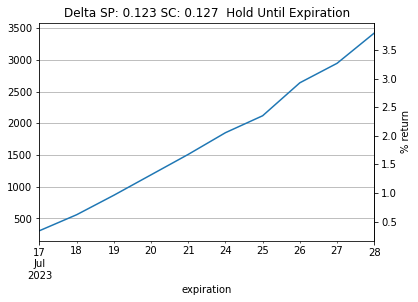

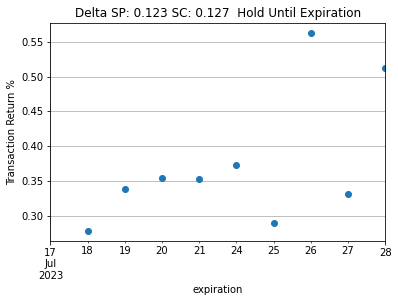

In [15]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(commission, 1, purchase_time, dos)
ex_pol = HoldToExpStaticExitPolicy(commission, '16:00:00')
strat = StaticEntryStaticExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

# Strikes for tomorrow with current best

In [16]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [17]:
dos = DeltaOptionSelector(short_puts=trial.params['delta_sp'],short_calls=trial.params['delta_sc'])
ent_pol=OptionSelectorStaticEntryPolicy(commission, 1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-07-28,2023-07-31,0.122672,4545.0,0.111261,160.0,0.126892,4615.0,0.111675,150.0,2,310.0


# Strikes following the 4/2 Strategy

In [18]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(commission, 1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,trade_count,collected
0,2023-07-28,2023-07-31,0.04,4520.0,0.037666,50.0,0.02,4650.0,0.017805,20.0,2,70.0
